In [1]:
from math import sqrt
import pandas as pd
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"

import numpy as np
rng = np.random.default_rng()

## Tune BASE_REWARD_FACTOR higher to "speed up" the simulation
BASE_REWARD_FACTOR = 2 ** 16
BASE_REWARDS_PER_EPOCH = 4
PROPOSER_REWARD_QUOTIENT = 8
MIN_DEPOSIT_SIZE = 32000000000
SLOTS_PER_EPOCH = 32

def eth_to_gwei(eth):
    return eth * (10 ** 9)

def integer_squareroot(n):
    """
    Return the largest integer ``x`` such that ``x**2 <= n``.
    """
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x

def balances_to_num_deposits(validator_balances):
    return [balance // MIN_DEPOSIT_SIZE for balance in validator_balances]

def get_total_num_deposits(validator_balances):
    return sum(balances_to_num_deposits(validator_balances))

def get_effective_balances(validator_balances):
    return [MIN_DEPOSIT_SIZE * balance // MIN_DEPOSIT_SIZE for balance in validator_balances]

def normalise(xs):
    return [x / sum(xs) for x in xs]

def get_base_reward(validator_balances):
    total_balance = sum(get_effective_balances(validator_balances))
    return MIN_DEPOSIT_SIZE * BASE_REWARD_FACTOR // integer_squareroot(total_balance)

def get_variance(validator_balances):
    mean_bal = np.mean(validator_balances)
    return sum([(bal - mean_bal) ** 2 for bal in validator_balances]) / (len(validator_balances) - 1)

def get_epoch_rewards_random(validator_balances):
    base_reward = get_base_reward(validator_balances)
    num_deposits = balances_to_num_deposits(validator_balances)
    
    proposer_reward = base_reward // 8
    attester_reward = 7 * base_reward // 8
    
    total_deposits = get_total_num_deposits(validator_balances)
    total_attestations = 0
    proposers = rng.choice(np.arange(len(validator_balances)), SLOTS_PER_EPOCH, p = normalise(num_deposits))
    
    proposer_deltas = [0 for i in range(len(validator_balances))]
    attester_deltas = [num_deposits[validator] * attester_reward for validator in range(len(validator_balances))]

    for slot, proposer in enumerate(proposers):
        attestations_in_slot = total_deposits // SLOTS_PER_EPOCH
        attestations_in_slot += 1 if slot < total_deposits % SLOTS_PER_EPOCH else 0
        total_attestations += attestations_in_slot
        total_proposer_reward = proposer_reward * attestations_in_slot
        proposer_deltas[proposer] += total_proposer_reward
        
    assert total_attestations == total_deposits
    
    deltas = [proposer_delta + attester_delta for proposer_delta, attester_delta \
              in zip(proposer_deltas, attester_deltas)]
    
    return deltas

def get_epoch_rewards_constant(validator_balances):
    base_reward = get_base_reward(validator_balances)
    num_deposits = balances_to_num_deposits(validator_balances)
    total_deposits = get_total_num_deposits(validator_balances)
    total_rewards = base_reward * total_deposits
    deltas = [total_rewards * num_deposit / total_deposits for num_deposit in num_deposits]
    return deltas

### From https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [2]:
def update_balances(params, step, sH, s, _input):
    validator_balances = s["validator_balances"]
    if params["validator_balances"]["reward_mode"] == "constant":
        deltas = get_epoch_rewards_constant(validator_balances)
    else:
        deltas = get_epoch_rewards_random(validator_balances)
    new_balances = [balance + delta for balance, delta in zip(validator_balances, deltas)]
    return ("validator_balances", new_balances)

psubs = [
    {
        "policies": {},
        "variables": {
            "validator_balances": update_balances,
        }
    }
]

In [3]:
def process_data(df):
    df["total_deposits"] = df.validator_balances.apply(
        lambda b: get_total_num_deposits(b)
    )
    df["min_income"] = df.validator_balances.apply(
        lambda b: min(b)
    )
    df["max_income"] = df.validator_balances.apply(
        lambda b: max(b)
    )
    df["max_by_min"] = df.apply(
        lambda row: row.max_income / row.min_income,
        axis = 1
    )
    df["max_minus_min"] = df.apply(
        lambda row: row.max_income - row.min_income,
        axis = 1
    )
    df["subset"] = df.subset.apply(
        lambda subset: "Constant income" if subset == 0 else "Random income"
    )
    df["richest"] = df.apply(
        lambda row: row.validator_balances.index(row.max_income),
        axis = 1
    )
    df["gini"] = df.validator_balances.apply(
        lambda b: gini_coefficient(np.array(b))
    )

## Methodology

In this simple simulation, we have _stakers_ who each run a certain number of _validators_. We follow the "abstract" dynamics of eth2:

- A validator earns a return on their 32 ETH principal. On average, this return per epoch is equal to one base reward.
- On average, 7/8th of the base reward is given for attesting duties, and 1/8th is given for block proposing.

We run two experiments, each with a different initial conditions:

- In the first experiment, all stakers start with the same number of validators (set to 1 validator per staker).
- In the second experiment, staker `i` starts with `i` validators.

For each experiment, we consider two regimes:

- In one, a validator makes a _constant_ income each epoch, equal to one base reward.
- In the other, we sample validators at _random_ to propose blocks, and thus some luckier validators get to propose more blocks and obtain more rewards.

Over time, we obtain the number of validators run by each staker by taking the integer division of the staker's balance with 32 ETH. In other words, as soon as a staker has accumulated 32 ETH from their staking, they activate a new validator. When a staker's balance is $b$, they run $i$ validators such that $32 \times i \leq b < 32 \times (i+1)$. Note that the residual balance $b - 32 \times i$ is "useless" until it is converted into a new validator.

## Quick takeaways

We study two inequality forces:

- Inequality of initial conditions: "rich get richer"
- Inequality of random outcomes: "lucky get richer"

Although each brings the same outcome (higher inequality), their nature is very different. It may be useful to keep in mind when analysing the long-term behaviour of validators regarding MEV extraction and pooling. In a sense, pooling reduces inequality: all validators in a pool are given a constant income each epoch, in aggregate roughly proportional to the size of the pool relative to all other stakers. On the other hand, since MEV is random (some blocks contain lots of MEV), this force exacerbates inequality.

## First experiment: 100 equal-sized stakers

In [4]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

runs = 10
duration = int(1e3)
num_vals = 100

sim_config_dict = {
    'T': range(duration),
    'N': runs,
    'M': {
        "validator_balances": [
            { "reward_mode": "constant" },
            { "reward_mode": "random" },
        ]
    }
}

initial_conditions = {
    "validator_balances": [eth_to_gwei(x) for x in [32 for y in range(1,num_vals+1)]]
}

exp.append_configs(initial_state=initial_conditions,
                   partial_state_update_blocks=psubs,
                   sim_configs=config_sim(sim_config_dict))

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs)
raw_result, tensor, sessions = executor.execute()

%matplotlib inline
import pandas as pd
df_equal = pd.DataFrame(raw_result)
process_data(df_equal)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 20
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 1, 1, 1)


Initializing configurations:   0%|          | 0/20 [00:00<?, ?it/s]

Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized


Flattening results:   0%|          | 0/20 [00:00<?, ?it/s]

Total execution time: 2.00s


We compute the Gini coefficient of staker balances over time. Remember:

- Gini = 0 => perfect equality
- Gini = 1 => perfect inequality

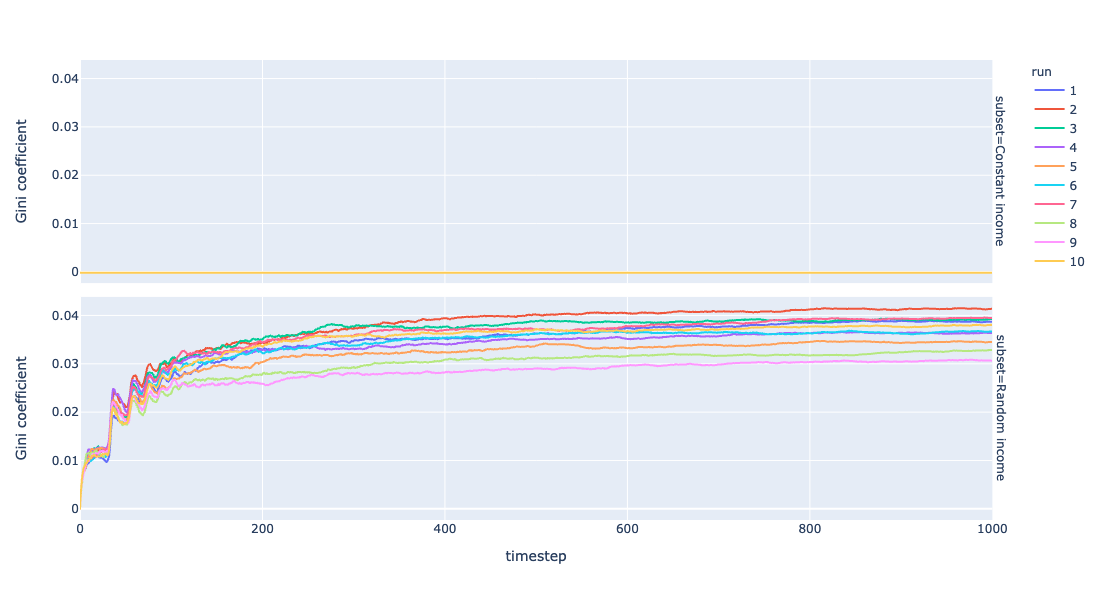

In [5]:
height = 600
width = 800
px.line(df_equal, x='timestep', y='gini', line_group='run', color='run', facet_row='subset', height=height, width=width, labels={'gini': "Gini coefficient"})

When all validators receive a constant income each epoch, the inequality measure is constant: all incomes increase at the same rate, so equal-sized validators remain equal-sized throughout.

However, when equal-sized validators receive a random income (based on how often they get to propose a block), inequality increases as luckier validators activate new validators quicker.

From the plot below, we can see deposits are activated in a roughly constant manner in both cases.

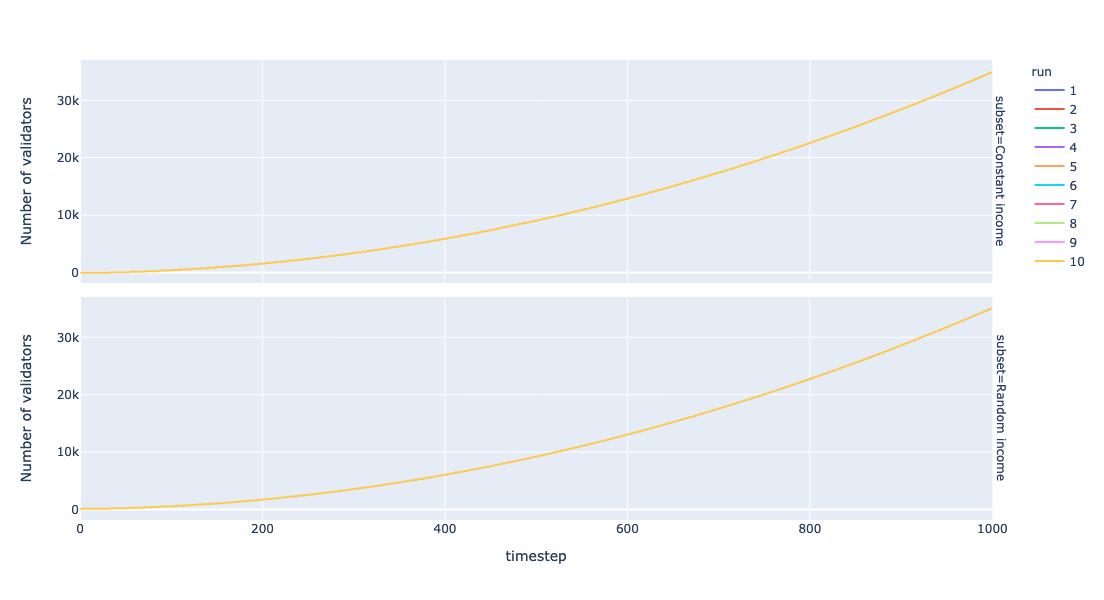

In [6]:
px.line(df_equal, x='timestep', y='total_deposits', line_group='run', color='run', facet_row='subset', height=height, width=width, labels={'total_deposits': 'Number of validators'})

## Second experiment: 100 unequal-sized validators

In [7]:
%%capture

from cadCAD import configs
del configs[:]

exp = Experiment()

runs = 500
duration = int(1e3)
num_vals = 100

sim_config_dict = {
    'T': range(duration),
    'N': runs,
    'M': {
        "validator_balances": [
            { "reward_mode": "constant" },
            { "reward_mode": "random" },
        ]
    }
}

initial_conditions = {
    "validator_balances": [eth_to_gwei(x) for x in [32 * y for y in range(1,num_vals+1)]]
}

exp.append_configs(initial_state=initial_conditions,
                   partial_state_update_blocks=psubs,
                   sim_configs=config_sim(sim_config_dict))

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs)
raw_result, tensor, sessions = executor.execute()

%matplotlib inline
import pandas as pd
df_unequal = pd.DataFrame(raw_result)
process_data(df_unequal)

We do here 500 runs of the simulation and plot the ensemble mean of the Gini coefficient for both the constant and random income cases. Surprisingly, it appears the ensemble mean of the random income case is tracking the Gini coefficient of the constant income case!

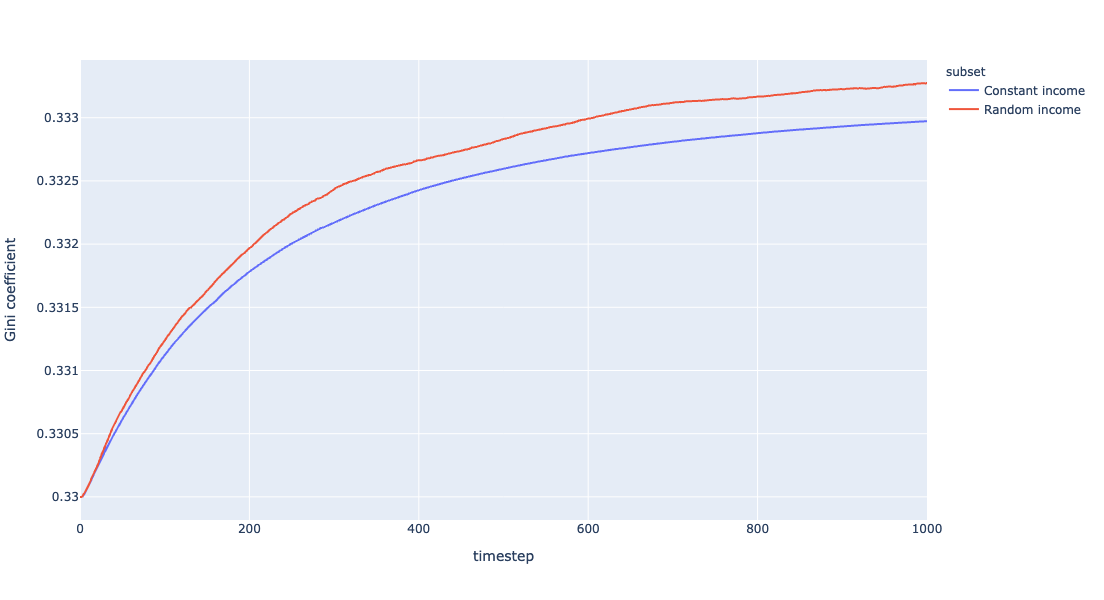

In [8]:
df_unequal_grouped = df_unequal[["timestep", "gini", "subset"]].groupby(["timestep", "subset"]).mean().reset_index()
px.line(df_unequal_grouped, x='timestep', y='gini', line_group='subset', color='subset', height=height, width=width, labels={'gini': "Gini coefficient"})

With validators starting from unequal balances, we observe inequality increases in both the constant income and the random income regimes.

In other words this is the situation:

| | Equal-sized validators | Unequal-sized validators |
|-|-|-|
| Constant income | Inequality is constant | Inequality increases |
| Random income | Inequality increases | Inequality increases _the same as in constant income case_ |

It's interesting to note that inequality does converge to some value. Formal analysis of concentration in Proof-of-Stake were performed before (e.g., [Compounding of Wealth in Proof-of-Stake Cryptocurrencies](https://fc19.ifca.ai/preproceedings/161-preproceedings.pdf)), and such models would probably explain why we observe what we observe here, including why the unequal-sized + random income model performs in expectation like the unequal-sized + constant income model.

## Ideas towards a more formal analysis of PoS/MEV

- There is a random process governing who proposes blocks, with the number of blocks proposed by a single validator over $S$ slots if there are $N$ validators in the system given by a binomial distribution $\mathcal{B}(\frac{1}{N}, S)$
- There is a random process of how much MEV you obtain when proposing a block, if you extract it, with MEV per block distributed according to some $F$
- As a single validator who extracts MEV, your revenue over $S$ slots is the random variable $X_M = \sum_{i = 1}^S \eta_i (R + M_i)$, where $\eta_i$ is a Bernoulli random variable with probability $\frac{1}{N}$, $R$ is the reward from proposing the block and $M_i \sim F$ is the MEV extracted
- If you don't extract MEV, your revenue is $X = R \sum_{i = 1}^S \eta_i$
- If you participate in a pool with stake $\gamma$ (in ETH), then your income from block proposing is $Y = S \cdot \frac{\gamma}{32 N} \cdot R$ (we assume the pool is large enough to remove the variance of block proposing, so note that if $\gamma = 32$, you recover the expectation of the random variable $X$ above; also assumed that pool fees are zero, otherwise multiply the expression by $(1-f)$ where $f$ is the percentage of fees)
- Additionally if the pool participates in MEV extraction (again assuming it is large enough so that they extract the expectation of $M \sim F$), then the validator receives $Y_M = S \cdot \frac{\gamma}{32N} \cdot (R + \mathbb{E}[M])$ (note once again that for $\gamma = 32, Y_M = \mathbb{E}[X_M]$)